In [1]:
%run Spacecraft-Model.ipynb

In [2]:
%run ADCS-Controller.ipynb

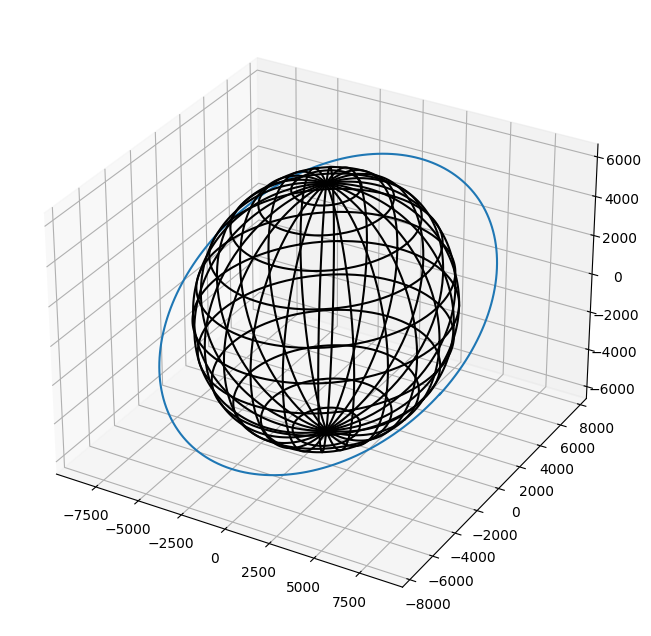

In [3]:
# Graph the spacecraft's orbit
dt = 0.1
s1 = Spacecraft_Model(dt)
s1.graph_orbit()

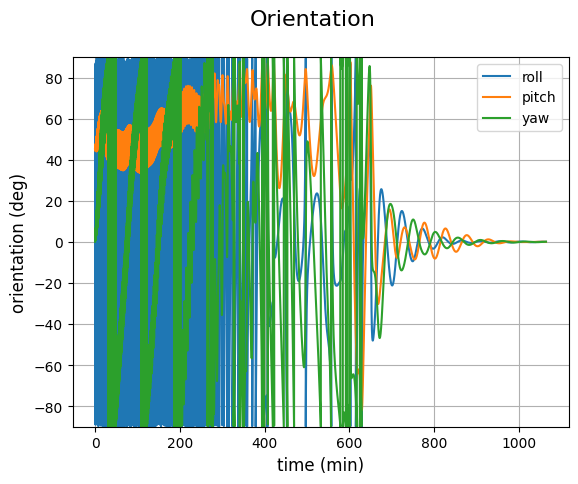

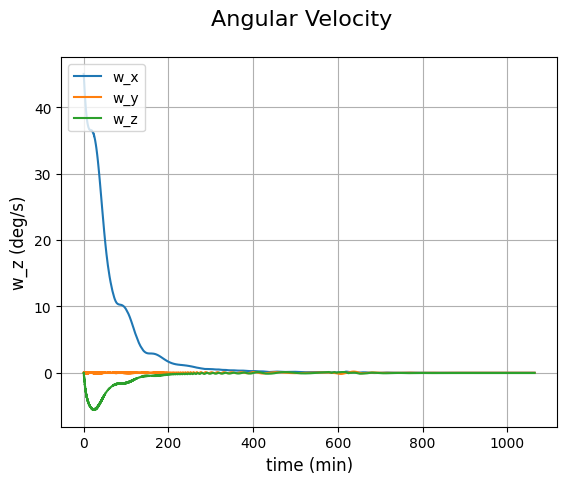

In [4]:
# Create the spacecraft and ADCS models
dt = 1
s2 = Spacecraft_Model(dt)
adcs = ADCS()

# Determine the length of the simulation
time = np.arange(0,Spacecraft_Model.orbit_len * 8,dt)

# Create structures to hold all the simulation data
roll_history, pitch_history, yaw_history = np.zeros(len(time)), np.zeros(len(time)), np.zeros(len(time)) # pointing error
q_history = np.zeros((len(time), 4)) # attitude
w_history = np.zeros((len(time), 3)) # angular velocity
m_history = np.zeros((len(time), 3)) # magnetic moment
attitude_err_history = np.zeros((len(time), 3)) # attitude error calcluated by the PD controller
torque_ideal_history = np.zeros((len(time),3)) # ideal torque
torque_actual_history = np.zeros((len(time),3)) # actual torque
acc_history = np.zeros((len(time),3)) # angular acceleration
torque_dot_history = np.zeros((len(time),3)) # dot product between ideal and generated torque

# Helper function to check if the spacecraft has detumbled to less than 0.1 deg/s
def detumble_threshold(arr):
    return np.linalg.norm(arr) <= 0.1 * (np.pi / 180)

# Inertia of the spacecraft
J = inertia(6, 0.34, 0.1, 0.1)

# Variables to record start and end of pointing
point_start = 0
point_end = time.size - 1

# Temporary variables to save data
under_threshold = 0
attitude_err = 0
acc = 0
m = np.zeros(3)
torque_ideal = np.zeros(3)
torque_actual = np.zeros(3)
torque_dot = np.zeros(3)
pointing = False

# Start ADCS
adcs.send("on_initialization")

# Run simulation
for i in range(time.size):
    # Advance the spacecraft
    pos, cang, mag_field = s2.tick(m, torque_ideal)

    # Determine if the ADCS has stopped detumbling
    # and put the ADCS into the pointing mode
    if under_threshold == 60 and not pointing:
        adcs.send('to_pointing')
        point_start = i
        pointing = True

    # Run the ADCS controller
    if adcs.current_state.id == 'pointing':
        adcs.point(mag_field, q_target, q_curr, Spacecraft_Model.w_nominal_b, s2.w_t)
        attitude_err = adcs.get_attitude_err(q_target, q_curr)
        torque_ideal = adcs.get_pointing_torque(q_target, q_curr, Spacecraft_Model.w_nominal_b, s2.w_t)
        torque_actual = cross(adcs.get_moment(), mag_field)
        acc = s2.get_angular_acceleration(m, torque_ideal)
        torque_dot = np.dot(torque_actual, torque_ideal)
    else:
        adcs.detumble(mag_field, cang)
        torque_ideal = cross(adcs.get_moment(), mag_field)
        torque_actual = cross(adcs.get_moment(), mag_field)
        
    m = adcs.get_moment()
    
    # Calculate ideal orientation
    r = s2.get_position()
    v = s2.get_velocity()
    
    # Find the ideal orientation of the spacecraft in the ICRF
    b_x = -normalize(r)
    b_y = normalize(v)
    b_z = cross(b_x, b_y)

    # Construct the nominal DCM from inertial to body from the body axes
    # Compute the equilvalent quaternion
    dcm_target = np.stack([b_x, b_y, b_z])
    q_target = dcm_to_quaternion(dcm_target)

    # Calculate the difference between the desired orientation and the current orientation
    q_curr = s2.q_t
    q_err = quaternion_multiply(q_curr, quaternion_inverse(q_target))

    # Calculate the error in each of the 3 axis
    pitch_history[i] = np.arcsin(-2*(q_err[0]*q_err[2] - q_err[1]*q_err[3]))
    roll_history[i] = np.arctan(2*(q_err[1]*q_err[2] + q_err[0]*q_err[3]) / (q_err[3]**2 - q_err[0]**2 - q_err[1]**2 + q_err[2]**2))
    yaw_history[i] = np.arctan(2*(q_err[0]*q_err[1] + q_err[2]*q_err[3]) / (q_err[3]**2 + q_err[0]**2 - q_err[1]**2 - q_err[2]**2))
    
    # Save all simulation data from this time step
    q_history[i] = s2.q_t
    w_history[i] = s2.w_t
    m_history[i] = m
    attitude_err_history[i] = attitude_err
    torque_ideal_history[i] = torque_ideal
    torque_actual_history[i] = torque_actual
    acc_history[i] = acc
    torque_dot_history[i] = torque_dot

    # Determine if the angular acceleration is under the detumbling threshold
    if detumble_threshold(w_history[i]):
        under_threshold += 1
    else:
        under_threshold = 0

# Convert time to minutes
time = time / 60

# Plot Orientation:
fig1 = plt.figure()
fig1.suptitle('Orientation', fontsize=16)

ax1 = fig1.add_subplot()
ax1.plot(time, np.rad2deg(roll_history), label="roll")
ax1.plot(time, np.rad2deg(pitch_history), label="pitch")
ax1.plot(time, np.rad2deg(yaw_history), label="yaw")
ax1.set_ylabel('orientation (deg)', fontsize=12)
ax1.set_xlabel('time (min)', fontsize=12)
ax1.set(ylim=(-90,90))
ax1.legend(loc="upper right")
ax1.grid(True)

# Plot angular velocity
fig2 = plt.figure()
fig2.suptitle('Angular Velocity', fontsize=16)

# Plot rolling:
ax1 = fig2.add_subplot()
ax1.plot(time, np.rad2deg(w_history[:, 0]), label="w_x")
ax1.plot(time, np.rad2deg(w_history[:, 1]), label="w_y")
ax1.plot(time, np.rad2deg(w_history[:, 2]), label="w_z")
ax1.set_ylabel('w_z (deg/s)', fontsize=12)
ax1.set_xlabel('time (min)', fontsize=12)
ax1.legend(loc="upper left")
ax1.grid(True)

"""
# Plot moment
fig3 = plt.figure()
fig3.suptitle('Magnitude of Moment', fontsize=16)

ax1 = fig3.add_subplot()
ax1.plot(time, m_history[:,0], label="x")
ax1.plot(time, m_history[:,1], label="y")
ax1.plot(time, m_history[:,2], label="z")
ax1.set_ylabel('m (Am^2)', fontsize=12)
ax1.set_xlabel('time (min)', fontsize=12)
ax1.legend(loc="upper left")
ax1.grid(True)

# Plot desired torque
fig4 = plt.figure()
fig4.suptitle('Desired Torque', fontsize=16)

ax1 = fig4.add_subplot()
ax1.plot(time, np.rad2deg(torque_ideal_history[:,0]), label="x")
ax1.plot(time, np.rad2deg(torque_ideal_history[:,1]), label="y")
ax1.plot(time, np.rad2deg(torque_ideal_history[:,2]), label="z")
ax1.set_ylabel('error (degrees)', fontsize=12)
ax1.set_xlabel('time (min)', fontsize=12)
ax1.legend(loc="upper left")
ax1.grid(True)

# Plot actual torque used
fig5 = plt.figure()
fig5.suptitle('Actual Torque', fontsize=16)

ax1 = fig5.add_subplot()
ax1.plot(time, np.rad2deg(torque_actual_history[:,0]), label="x")
ax1.plot(time, np.rad2deg(torque_actual_history[:,1]), label="y")
ax1.plot(time, np.rad2deg(torque_actual_history[:,2]), label="z")
ax1.set_ylabel('error (degrees)', fontsize=12)
ax1.set_xlabel('time (min)', fontsize=12)
ax1.legend(loc="upper left")
ax1.grid(True)

# Plot dot product between desired torque and actual torque
fig6 = plt.figure()
fig6.suptitle('Dot Product', fontsize=16)

ax1 = fig6.add_subplot()
ax1.plot(time, np.rad2deg(torque_dot_history[:,0]), label="x")
ax1.plot(time, np.rad2deg(torque_dot_history[:,1]), label="y")
ax1.plot(time, np.rad2deg(torque_dot_history[:,2]), label="z")
ax1.set_ylabel('error (degrees)', fontsize=12)
ax1.set_xlabel('time (min)', fontsize=12)
ax1.legend(loc="upper left")
ax1.grid(True)
"""
plt.show()